In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival

In [2]:
# Load training data
UROMOL = pd.read_csv("./data/UROMOL.csv")
UROMOL_clinical = UROMOL.iloc[:, 0:17]
UROMOL_expression = pd.read_csv("./data/UROMOL_sigExpression.csv")

In [3]:
# Clinical feature processing
numeric_features = ["Age"]
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

categorical_features = ["Sex", "Smoking", "Concomitant.CIS", "Incident.tumor", "BCG"]
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="unknown"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)

ordinal_features = ["Tumor.size", "EAU.risk", "UROMOL2021.classification"]
size_ord = ["< 3 cm", ">= 3 cm"]
risk_ord = ["Low", "Intermediate", "High"]
class_ord = ["Class 1", "Class 2a", "Class 2b", "Class 3"]
ordinal_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=[size_ord, risk_ord, class_ord], dtype=int)
)

drop_features = ["UROMOL.ID", "Progression", "PFS_time.", "FUtime_days.", "Tumor.stage", "Tumor.grade"]

UROMOL_survival = Surv.from_dataframe(
    event="Recurrence",
    time="RFS_time",
    data=UROMOL_clinical
)

In [4]:
# Clinical data transformation
clinical_preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features)
)
transformed_UROMOL_clinical = clinical_preprocessor.fit_transform(UROMOL_clinical)
# pd.DataFrame(transformed_UROMOL_clinical, columns=clinical_preprocessor.get_feature_names_out())

In [5]:
# Feature importance
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(transformed_UROMOL_clinical, UROMOL_survival)
pd.Series(scores, index=clinical_preprocessor.get_feature_names_out()).sort_values(ascending=False)

pipeline-3__BCG_0                        0.577855
pipeline-3__BCG_1                        0.577855
pipeline-2__EAU.risk                     0.559779
pipeline-3__Incident.tumor_No            0.551791
pipeline-3__Incident.tumor_Yes           0.551791
pipeline-2__UROMOL2021.classification    0.544386
pipeline-3__Sex_F                        0.530740
pipeline-3__Sex_M                        0.530740
pipeline-3__Concomitant.CIS_No           0.526754
pipeline-3__Concomitant.CIS_Yes          0.526754
pipeline-3__Smoking_Current              0.526325
pipeline-3__Smoking_Never                0.526279
pipeline-1__Age                          0.519809
pipeline-3__Smoking_unknown              0.518781
pipeline-3__Smoking_Former               0.518735
pipeline-2__Tumor.size                   0.513707
dtype: float64

In [6]:
# Clinical model
clinical_model = Pipeline([
    ("preprocess", clinical_preprocessor),
    ("cox_ph", CoxPHSurvivalAnalysis())
])

In [7]:
# Clinical model training
clinical_model.fit(UROMOL_clinical, UROMOL_survival)
clinical_risk_train = clinical_model.predict(UROMOL_clinical)

In [8]:
# Expression data transformation
expression_preprocessor = make_pipeline(
    KNNImputer(n_neighbors=10, weights="distance"),
    StandardScaler()
)
transformed_UROMOL_expression = expression_preprocessor.fit_transform(UROMOL_expression)
# pd.DataFrame(transformed_UROMOL_expression, columns=expression_preprocessor.get_feature_names_out())

In [9]:
# Expression model
expr_pipeline = Pipeline([ ("preprocess", expression_preprocessor),
                           ("cox_net", CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.1, max_iter=10000))
                         ])

# Hyperparameter selection
expr_pipeline.fit(UROMOL_expression, UROMOL_survival)

candidate_alphas = expr_pipeline.named_steps["cox_net"].alphas_

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

splits = cv.split(UROMOL_expression, UROMOL_survival["Recurrence"])

def cindex_scorer(estimator, X, y):
    pred = estimator.predict(X)
    return concordance_index_censored(y["Recurrence"], y["RFS_time"], pred)[0]

param_grid = { "cox_net__alphas": [[float(a)] for a in candidate_alphas] }
gcv = GridSearchCV( estimator=expr_pipeline, param_grid=param_grid, cv=splits, scoring=cindex_scorer, n_jobs=-1, error_score="raise" )
gcv.fit(UROMOL_expression, UROMOL_survival)

print("Best alpha:", gcv.best_params_)
print("Best CV C-index:", gcv.best_score_)

Best alpha: {'cox_net__alphas': [0.039667188549215734]}
Best CV C-index: 0.6452024024360445


In [10]:
# Expression model training
expression_model = gcv.best_estimator_
expression_model.fit(UROMOL_expression, UROMOL_survival)

expression_risk_train = expression_model.predict(UROMOL_expression)

In [11]:
# Combined model training
risk_train = pd.DataFrame({
    "clinical_risk": clinical_risk_train,
    "expression_risk": expression_risk_train
})

combined_model = CoxPHSurvivalAnalysis()
combined_model.fit(risk_train, UROMOL_survival)

combined_risk_train = combined_model.predict(risk_train)

In [12]:
# C-index
def c_index(risk, combined_score, survival):
    cindex_clinical = concordance_index_censored(
        survival["Recurrence"], survival["RFS_time"], risk["clinical_risk"]
    )[0]
    
    cindex_expr = concordance_index_censored(
        survival["Recurrence"], survival["RFS_time"], risk["expression_risk"]
    )[0]
    
    cindex_combined = concordance_index_censored(
        survival["Recurrence"], survival["RFS_time"], combined_score
    )[0]
    
    print("Clinical C-index:", cindex_clinical)
    print("Expression C-index:", cindex_expr)
    print("Combined C-index:", cindex_combined)


In [13]:
# C-index training score
c_index(risk_train, combined_risk_train, UROMOL_survival)

Clinical C-index: 0.6380166809763277
Expression C-index: 0.8376671163988716
Combined C-index: 0.8391389672513185


In [14]:
# Feature importance of clinical model
clinical_coefs = pd.Series(
    clinical_model.named_steps["cox_ph"].coef_,
    index=clinical_model.named_steps["preprocess"].get_feature_names_out()
).sort_values(key=abs, ascending=False)

print(clinical_coefs)

pipeline-3__Concomitant.CIS_Yes          3.876102
pipeline-3__Concomitant.CIS_No           3.564999
pipeline-3__Incident.tumor_Yes          -2.947461
pipeline-3__Incident.tumor_No           -2.687047
pipeline-3__Smoking_Former               1.784684
pipeline-3__Smoking_Current              1.749262
pipeline-3__Sex_F                        1.674593
pipeline-3__Smoking_unknown              1.285043
pipeline-3__Smoking_Never                1.262266
pipeline-3__Sex_M                        1.231941
pipeline-3__BCG_1                        0.536027
pipeline-2__Tumor.size                   0.340389
pipeline-3__BCG_0                       -0.188030
pipeline-2__UROMOL2021.classification    0.114142
pipeline-1__Age                         -0.030634
pipeline-2__EAU.risk                     0.017162
dtype: float64


In [15]:
# Feature importance of expression model
signature = pd.Series(expression_model.named_steps["cox_net"].coef_.ravel(), index=UROMOL_expression.columns)
signature = signature[signature != 0].sort_values(key=np.abs, ascending=False)

print("Non-zero genes:", signature.shape[0])
print(signature.sort_values(key=abs, ascending=False))

Non-zero genes: 108
LncRNA1061_ENSG00000232807    0.239541
RN7SKP255                     0.213988
CLEC10A                       0.187897
AATK                          0.186400
SH3RF1                        0.179798
                                ...   
CDKN2B                       -0.003006
NANOG                         0.002810
TFPI2                        -0.001589
SLC38A5                      -0.000955
SEC16B                        0.000614
Length: 108, dtype: float64


In [16]:
# Kaplan-Meier curve
def KM_curve(risk_score, survival):
    
    # split by median
    cutoff = np.median(risk_score)
    high_risk = risk_score > cutoff
    
    # KM for low risk
    time_low, surv_low = kaplan_meier_estimator(
        survival["Recurrence"][~high_risk],
        survival["RFS_time"][~high_risk]
    )
    
    # KM for high risk
    time_high, surv_high = kaplan_meier_estimator(
        survival["Recurrence"][high_risk],
        survival["RFS_time"][high_risk]
    )

    # log-rank test
    groups = high_risk.astype(int)
    chisq, pval = compare_survival(survival, groups)

    # plot
    plt.figure(figsize=(7, 5))
    
    plt.step(time_low, surv_low, where="post", label="Low risk")
    plt.step(time_high, surv_high, where="post", label="High risk")
    
    plt.title("Kaplan-Meier Curve: High vs Low Risk")
    plt.xlabel("Time")
    plt.ylabel("Recurrence-free survival probability")
    plt.grid(True)
    plt.legend()
    plt.show()

    return pval

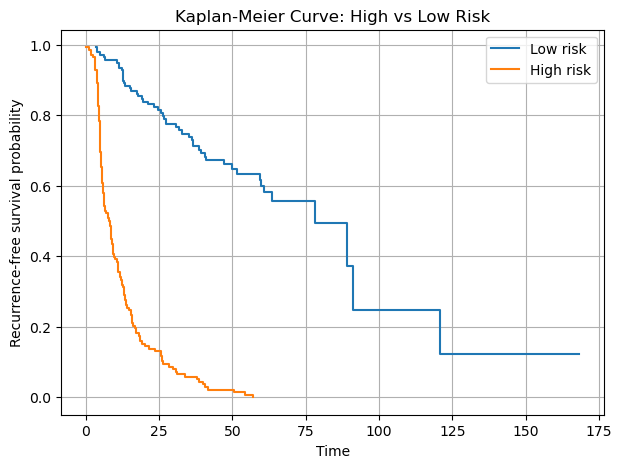

np.float64(5.676956972860117e-48)

In [17]:
# KM curve training
KM_curve(combined_risk_train, UROMOL_survival)

In [18]:
# Load testing data
knowles = pd.read_csv("./data/knowles.csv")
knowles["RFS_time"] = np.where(
    knowles["Recurrence"] == 1,
    knowles["RFS_time"],
    knowles["FUtime_days."] / 30
)
knowles = knowles.dropna(subset=["Recurrence", "RFS_time"])

In [19]:
# Prepare clinical testing data
knowles_clinical = knowles.loc[:, ~knowles.columns.str.startswith("exprs.")]
knowles_clinical['UROMOL2021.classification'] = knowles_clinical['UROMOL2021.classification'].str.replace('_', ' ', regex=False)
knowles_clinical = knowles_clinical.reindex(columns=UROMOL_clinical.columns, fill_value=np.nan)
# transformed_knowles_clinical = clinical_preprocessor.transform(knowles_clinical)

In [20]:
# Prepare expression testing data
knowles_expression = knowles.loc[:, knowles.columns.str.startswith("exprs.")]
knowles_expression = knowles_expression.reindex(columns=UROMOL_expression.columns, fill_value=np.nan)
# transformed_knowles_expression = expression_preprocessor.transform(knowles_expression)

In [21]:
# Prepare testing survival
knowles_survival = Surv.from_dataframe(
    event="Recurrence",
    time="RFS_time",
    data=knowles_clinical
)

In [22]:
# Predict testing data
risk_test = pd.DataFrame({
    "clinical_risk": clinical_model.predict(knowles_clinical),
    "expression_risk": expression_model.predict(knowles_expression)
})

combined_risk_test = combined_model.predict(risk_test)

In [23]:
# C-index testing
c_index(risk_test, combined_risk_test, knowles_survival)

Clinical C-index: 0.6495756718528995
Expression C-index: 0.5
Combined C-index: 0.6495756718528995


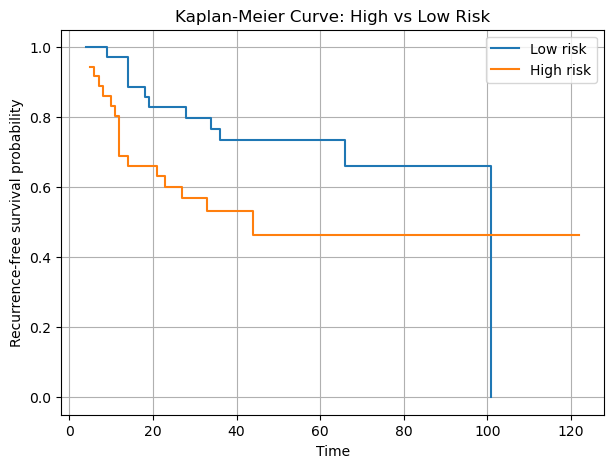

np.float64(0.06341619126307013)

In [24]:
# KM curve testing
KM_curve(combined_risk_test, knowles_survival)